In [194]:
!pip install tqdm

In [2]:
pip install pandas pyarrow

Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd
import numpy as np
import warnings
import nltk
import demoji
import pickle
import regex
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from scipy.sparse import csr_matrix
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore")

### Look at the data

In [7]:
path = '/Users/k.lusheva/IdeaProjects/emotion-classifier-group-project/data/data_vk_nlp04122023.parquet'

In [18]:
df_row = pd.read_parquet(path)

In [9]:
df_row = pd.read_parquet(path)
df_row.head(5)

,id,text,created_at,sentiment,emotion,toxicity,is_congratulation,spam
0,12963175,🎭 Многократно экранизированный и поставленный...,2023-11-01 11:40:28,POSITIVE,no_emotion,"TOXIC! Внимание, перед Вами токсичное сообщение!",False,Ham
1,12963451,Продолжает работу Осенний лагерь в нашей школе...,2023-11-01 15:08:04,POSITIVE,no_emotion,NOT TOXIC! Это сообщение не является грубым ил...,False,Spam
2,12963452,"Сегодня, мы съездили в с\nВоскресенское. Наша ...",2023-11-01 14:52:52,POSITIVE,no_emotion,NOT TOXIC! Это сообщение не является грубым ил...,False,Ham
3,12963698,Более 170 лекций запланировали в рамках просве...,2023-11-01 14:40:19,NEUTRAL,no_emotion,NOT TOXIC! Это сообщение не является грубым ил...,False,Spam
4,12963699,1 ноября у нас в гостях были воспитанники подг...,2023-11-01 09:56:06,NEUTRAL,no_emotion,NOT TOXIC! Это сообщение не является грубым ил...,False,Spam


In [19]:
df = df_row.drop(columns=['id', 'created_at'])

In [20]:
df.shape

(357147, 6)

In [21]:
df.value_counts('sentiment')

sentiment
NEUTRAL     256137
POSITIVE     73573
NEGATIVE     25291
Name: count, dtype: int64

In [22]:
df.value_counts('emotion')

emotion
no_emotion    280021
joy            42312
anger          15714
sadness         7684
surprise        7426
fear            3913
Name: count, dtype: int64

### Relationships between categorical features

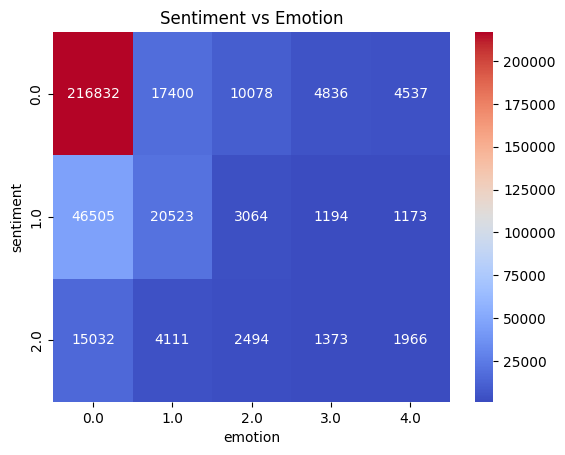

In [26]:
df1 = df[['sentiment','emotion','toxicity','is_congratulation','spam']]

df1.dropna()

df1.head()

df1['sentiment'] = df1['sentiment'].map({'POSITIVE':1, 'NEUTRAL':0, 'NEGATIVE':2})
df1['emotion'] = df1['emotion'].map({'no_emotion':0, 'joy':1, 'anger':2, 'surprise':3, 'sadness':4})
df1['toxicity'] = df1['toxicity'].map({'TOXIC! Внимание, перед Вами токсичное сообщение!':1, 'NOT TOXIC! Это сообщение не является грубым или токсичным.':0})
df1['is_congratulation'] = df1['is_congratulation'].map({True:1,False:0})
df1['spam'] = df1['spam'].map({'Spam':1, 'Ham':0,})

sentiment_emotion_contingency = pd.crosstab(df1['sentiment'], df1['emotion'])
sns.heatmap(sentiment_emotion_contingency_2, annot=True, cmap='coolwarm', fmt='d')
plt.title('Sentiment vs Emotion')
plt.show()
chi2_stat, p_val, _, _ = chi2_contingency(sentiment_emotion_contingency)

In [27]:
print("Contingency Table for Sentiment and Emotion:")
print(sentiment_emotion_contingency)
print("\nChi-square Statistic:", chi2_stat)
print("P-value:", p_val)

Contingency Table for Sentiment and Emotion:
emotion       0.0    1.0    2.0   3.0   4.0
sentiment                                  
0.0        216832  17400  10078  4836  4537
1.0         46505  20523   3064  1194  1173
2.0         15032   4111   2494  1373  1966

Chi-square Statistic: 33924.903348126565
P-value: 0.0


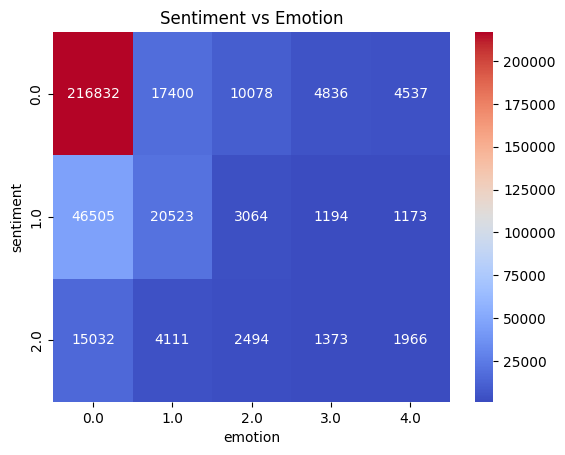

In [24]:
#Let's drop all data with 'neutral' sentiment and look at the heatmap again
df2 = df1[df1['sentiment'] != 'NEUTRAL']

sentiment_emotion_contingency_2 = pd.crosstab(df2['sentiment'], df2['emotion'])
sns.heatmap(sentiment_emotion_contingency_2, annot=True, cmap='coolwarm', fmt='d')
plt.title('Sentiment vs Emotion')
plt.show()

### Train basic models only on text

In [28]:
df.isna().sum()

text                    0
sentiment            2146
emotion                77
toxicity                0
is_congratulation       0
spam                 2146
dtype: int64

In [29]:
df = df[(df.sentiment == 'POSITIVE') | (df.sentiment == 'NEGATIVE')]

In [30]:
df.isna().sum()

text                 0
sentiment            0
emotion              0
toxicity             0
is_congratulation    0
spam                 0
dtype: int64

In [31]:
mapping = {'NEGATIVE': 0, 'POSITIVE':1}
df.replace({'sentiment': mapping}, inplace=True)

In [32]:
X = df['text']
y = df['sentiment'] 

In [33]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=123)

In [34]:
X_train = pd.DataFrame(Xtrain, columns=['text'])
y_train = pd.Series(ytrain, name='sentiment')

In [35]:
X_train_str = [str(x) for x in Xtrain]
X_test_str = [str(x) for x in Xtest]

    tf-idf

In [36]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train_str)
X_test_tfidf = tfidf.transform(X_test_str)

In [37]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [38]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [39]:
y_1 = logreg_model.predict(X_test_tfidf)
print(classification_report(ytest, y_1))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5068
           1       0.94      0.95      0.95     14705

    accuracy                           0.92     19773
   macro avg       0.90      0.89      0.90     19773
weighted avg       0.92      0.92      0.92     19773



    Box of Words

In [42]:
bow = CountVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_bow = bow.fit_transform(X_train_str)
X_test_bow = bow.transform(X_test_str)

In [43]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_bow, y_train)

LogisticRegression(max_iter=1000)

In [44]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_bow, y_train)

MultinomialNB()

In [45]:
y_logreg_bow = logreg_model.predict(X_test_bow)
print(classification_report(ytest, y_logreg_bow))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      5068
           1       0.96      0.94      0.95     14705

    accuracy                           0.93     19773
   macro avg       0.90      0.91      0.90     19773
weighted avg       0.93      0.93      0.93     19773



In [46]:
y_logreg_tfidf = logreg_model.predict(X_test_tfidf)
print(classification_report(ytest, y_logreg_tfidf))

              precision    recall  f1-score   support

           0       0.72      0.95      0.82      5068
           1       0.98      0.87      0.92     14705

    accuracy                           0.89     19773
   macro avg       0.85      0.91      0.87     19773
weighted avg       0.91      0.89      0.90     19773



In [47]:
y_nb_bow = nb_classifier.predict(X_test_bow)
print(classification_report(ytest, y_nb_bow))

              precision    recall  f1-score   support

           0       0.67      0.83      0.74      5068
           1       0.94      0.86      0.89     14705

    accuracy                           0.85     19773
   macro avg       0.80      0.84      0.82     19773
weighted avg       0.87      0.85      0.86     19773



In [48]:
y_nb_tfidf = nb_classifier.predict(X_test_tfidf)
print(classification_report(ytest, y_nb_tfidf))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73      5068
           1       0.91      0.90      0.91     14705

    accuracy                           0.86     19773
   macro avg       0.81      0.82      0.82     19773
weighted avg       0.86      0.86      0.86     19773



In [52]:
y_pred_bow = rf_classifier.predict(X_test_bow)
print(classification_report(ytest, y_pred_bow))

              precision    recall  f1-score   support

           0       0.56      0.93      0.70      5068
           1       0.97      0.74      0.84     14705

    accuracy                           0.79     19773
   macro avg       0.76      0.84      0.77     19773
weighted avg       0.86      0.79      0.80     19773



In [49]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

for i in tqdm(range(10), desc="Fitting Model"):
    rf_classifier.fit(X_train_tfidf, y_train)

y_pred_rf = rf_classifier.predict(X_test_tfidf)

Fitting Model: 100%|████████████████████████████| 10/10 [07:05<00:00, 42.50s/it]


In [50]:
print(classification_report(ytest, y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      5068
           1       0.95      0.95      0.95     14705

    accuracy                           0.93     19773
   macro avg       0.90      0.90      0.90     19773
weighted avg       0.93      0.93      0.93     19773



### Train model with additional features

In [62]:
#prepare data for another approach
#In this iteration let's also use the Neutral sentiment data, to look how it changes the quality.

df = df_row.drop(columns=['id', 'created_at'])
df = df.dropna()

X_n = df
y_n = X_n['sentiment']
X_n = X_n.drop(['sentiment'], axis=1)

In [63]:
X_n.head()

,text,emotion,toxicity,is_congratulation,spam
0,🎭 Многократно экранизированный и поставленный...,no_emotion,"TOXIC! Внимание, перед Вами токсичное сообщение!",False,Ham
1,Продолжает работу Осенний лагерь в нашей школе...,no_emotion,NOT TOXIC! Это сообщение не является грубым ил...,False,Spam
2,"Сегодня, мы съездили в с\nВоскресенское. Наша ...",no_emotion,NOT TOXIC! Это сообщение не является грубым ил...,False,Ham
3,Более 170 лекций запланировали в рамках просве...,no_emotion,NOT TOXIC! Это сообщение не является грубым ил...,False,Spam
4,1 ноября у нас в гостях были воспитанники подг...,no_emotion,NOT TOXIC! Это сообщение не является грубым ил...,False,Spam


In [64]:
# Method to clean the text from emoji, special characters and punctuation.

def text_processing(text):
    combined_pattern = regex.compile(r'(?:(?=\P{L})\p{Emoji}+|[^а-яА-ЯЁё\s\d\n])')
    processed_text = combined_pattern.sub('', text)
    processed_text = processed_text.replace('\n', '')
    return processed_text

In [ ]:
for i in tqdm(range(1000), desc = 'Processing...'):
    X_text = X_n['text'].apply(text_processing)

In [ ]:
# run this to save resulting dataframe with clean text

with open('text.pickle', 'wb') as f:
    pickle.dump(X_text, f, pickle.HIGHEST_PROTOCOL)

In [58]:
# run this to load pickled object with clean text

with open('text.pickle', 'rb') as f:
    X_text = pickle.load(f)

In [59]:
tfidf = TfidfVectorizer(ngram_range=(1,1))
X_text_tfidf = tfidf.fit_transform(X_text)

X_text_tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_text_tfidf)

In [65]:
# work with features so that OHE takes up less memory
X_ohe = X_n.drop(['text'], axis=1)

X_ohe['emotion'] = X_ohe['emotion'].map({'no_emotion':0, 'joy':1, 'anger':2, 'surprise':3, 'sadness':4})
X_ohe['toxicity'] = X_ohe['toxicity'].map({'TOXIC! Внимание, перед Вами токсичное сообщение!':1, 'NOT TOXIC! Это сообщение не является грубым или токсичным.':0})
X_ohe['is_congratulation'] = X_ohe['is_congratulation'].map({True:1,False:0})
X_ohe['spam'] = X_ohe['spam'].map({'Spam':1, 'Ham':0,})

In [66]:
X_feats = pd.get_dummies(X_ohe, drop_first=True)

X_feats

,emotion,toxicity,is_congratulation,spam
0,0.0,1,0,0
1,0.0,0,0,1
2,0.0,0,0,0
3,0.0,0,0,1
4,0.0,0,0,1
...,...,...,...,...
357142,0.0,0,0,1
357143,1.0,0,0,1
357144,0.0,0,0,1
357145,0.0,0,0,1


In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)

for i in tqdm(range(1000), desc="Truncating matrices.."):
    X_train_d = svd.fit_transform(X_train)
    X_test_d = svd.fit_transform(Xtest_n)

In [ ]:
# run this to save resulting dataframe with truncated text matrix

with open('svd_file.pickle', 'wb') as f:
    pickle.dump(X_text_d, f, pickle.HIGHEST_PROTOCOL)

In [68]:
# run this to load resulting dataframe with truncated text matrix

with open('svd_file.pickle', 'rb') as f:
    X_text_d = pickle.load(f)

In [69]:
newtext = pd.DataFrame(X_text_d)
newtext.shape

(355001, 100)

In [71]:
X_feats.isna().sum().sum()
# wait, what are these missing values?

3883

In [74]:
# we forgot to encode emotion: 'fear', so we will drop the lines where this value used to be. in future iterations we will include them again

fear = X_feats[X_feats['emotion'].isna()].index
X_feats = X_feats.drop(fear)
newtext = newtext.drop(fear)
newtext = newtext.reset_index(drop=True)
y_n = y_n.drop(fear)

In [75]:
for i in tqdm(range(10000)):
    X_merge = newtext.join(X_feats, how='inner')

100%|█████████████████████████████████████| 10000/10000 [12:27<00:00, 13.38it/s]


In [77]:
X_merge_with_y = X_merge.join(y_n, how='inner')

mapping = {'NEUTRAL': 0, 'POSITIVE':1, 'NEGATIVE':2}
X_merge_with_y.replace({'sentiment': mapping}, inplace=True)

y_n = X_merge_with_y['sentiment']
X_merge = X_merge_with_y.drop('sentiment', axis=1)
X_merge.columns = X_merge.columns.astype(str)

In [78]:
Xtrain_n, Xtest_n, ytrain_n, ytest_n = train_test_split(X_merge, y_n, test_size=0.2, random_state=125)

In [ ]:
lr = LogisticRegression(max_iter=2000)

for i in tqdm(range(1000), desc="Fitting Model"):
    lr.fit(Xtrain_n, ytrain_n)

In [80]:
with open('lr.pickle', 'rb') as f:
    lr = pickle.load(f)

In [81]:
y = lr.predict(Xtest_n)
print(classification_report(ytest_n, y))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85     50449
           1       0.82      0.10      0.18     14439
           2       0.48      0.19      0.27      4915

    accuracy                           0.74     69803
   macro avg       0.68      0.42      0.43     69803
weighted avg       0.74      0.74      0.67     69803



### Word2Vec with text

In [83]:
df = pd.read_parquet(path)
missing_rows = df[df.isnull().any(axis=1)].index
df = df.drop(missing_rows)

In [84]:
with open('text.pickle', 'rb') as f:
    X_text = pickle.load(f)

In [85]:
#Filter the stopwords to increase quality of vocabulary
nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))

def preprocess(text):
    tokens = text.lower().split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/k.lusheva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
text = pd.DataFrame(X_text.apply(preprocess))
text.head()

,text
0,"[многократно, экранизированный, поставленный, ..."
1,"[продолжает, работу, осенний, лагерь, нашей, ш..."
2,"[сегодня, съездили, своскресенское, наша, перв..."
3,"[лекций, запланировали, рамках, просветительск..."
4,"[ноября, гостях, воспитанники, подготовительно..."


In [87]:
y = df['sentiment']

text_y = text.join(y, how='inner')

mapping = {'NEUTRAL': 0, 'POSITIVE':1, 'NEGATIVE':2}
text_y.replace({'sentiment': mapping}, inplace=True)

y_n = text_y['sentiment']
text = text_y.drop('sentiment', axis=1)
text.columns = text.columns.astype(str)

In [ ]:
tokenized_text = [row for row in text['text']]

model = Word2Vec(vector_size=100, window=3, min_count=20, sg=0, sample=1e-4, alpha=0.03,
    min_alpha=0.0007,negative=20,workers=4)

for i in tqdm(range(10000)):
    model.build_vocab(tokenized_text)

 22%|███████▉                            | 2192/10000 [42:53<2:25:36,  1.12s/it]

In [ ]:
for i in tqdm(range(10000)):
    model.train(tokenized_text, total_examples=len(text), epochs=10)

In [89]:
def get_avg_vector(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv.key_to_index]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * vector_size

In [ ]:
text['vector'] = text['text'].apply(lambda x: get_avg_vector(x, model, 100))

X = np.array(text['vector'].tolist())

In [96]:
text

,text,vector
0,"[многократно, экранизированный, поставленный, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[продолжает, работу, осенний, лагерь, нашей, ш...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[сегодня, съездили, своскресенское, наша, перв...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[лекций, запланировали, рамках, просветительск...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[ноября, гостях, воспитанники, подготовительно...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
357142,"[особый, учебный, план, особые, внеурочные, за...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
357143,"[каникулы, детейа, учителя, дела, сидятучителя...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
357144,"[кредитуем, граждан, рфки, любаяпредоставляем,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
357145,"[вебинар, важную, тему, повысить, цену, отпугн...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [92]:
text_tr, text_ts, y_tr, y_ts = train_test_split(X, y_n, test_size=0.2, random_state=125)

In [ ]:
for i in tqdm(range(1000)):
    lr = LogisticRegression(max_iter=1000)
    lr.fit(text_tr, y_tr)

In [ ]:
y = lr.predict(text_ts)
print(classification_report(y_ts, y))